# Setup and Data Loading


## Imports

In [79]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from definitions import OULAD_DATA_DIR
from lib_ml.data_utils.oulad_preprocessing import load_data

## Data Imports

In [80]:
# Settings for better readability
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [81]:
# Path to the folder containing the data
datasets = load_data(data_folder=OULAD_DATA_DIR)

# Load the datasets
courses = datasets['courses']
assessments = datasets['assessments']
vle = datasets['vle']
student_info = datasets['student_info']
student_registration = datasets['student_registration']
student_assessment = datasets['student_assessment']
student_vle = datasets['student_vle']

In [82]:
#Dir to save plots to drive
# images_dir = '/content/drive/MyDrive/BSc_Thesis_Timothy/Data/OULADdiagrams/'
# plt.savefig(f"{images_dir}/abc.png")

# Exploratory Data Analysis

## Merging

In [51]:
# # Merging datasets for a comprehensive view
# merged_data = pd.merge(student_info, student_registration, on=['id_student', 'code_module', 'code_presentation'], how='left')
# merged_data = pd.merge(merged_data, student_assessment,  on=['id_student'], how='left')
# merged_data = pd.merge(merged_data, student_vle, on=['id_student', 'code_module', 'code_presentation'], how='left')

## Clicks to final result 1

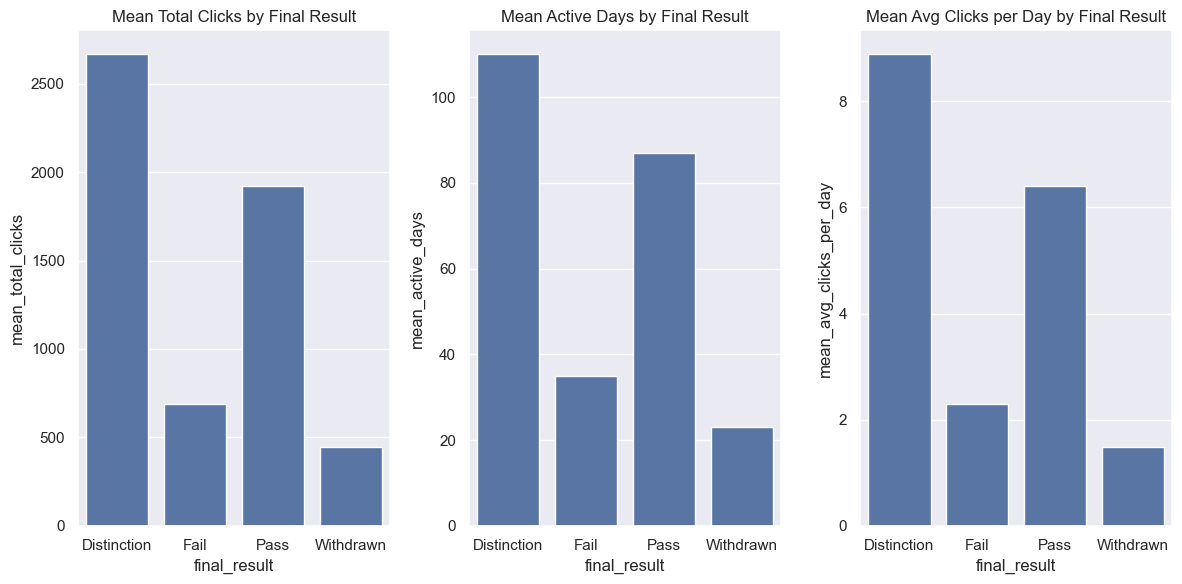

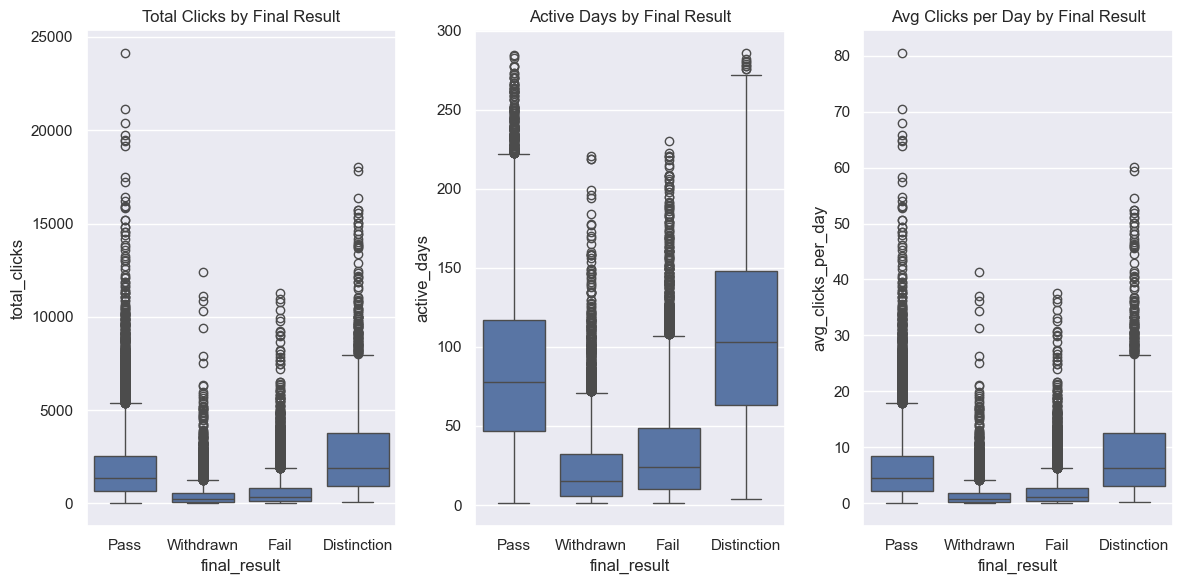

In [86]:
images_dir = '/plots/'


days = 132
# Filter out data after set date
student_vle = student_vle[student_vle['date'] < days]

vle_agg = student_vle.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    total_clicks=('sum_click', 'sum'),
    active_days=('date', 'nunique')
)

#calculates avg click per active day not total course days
vle_agg['avg_clicks_per_day'] = vle_agg['total_clicks'] / days

result_mapping = {'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3}

merged_data = pd.merge(vle_agg, student_info, on=['id_student', 'code_module', 'code_presentation'])

# Calculate the means for different final results
mean_values = merged_data.groupby('final_result').agg(
    mean_total_clicks=('total_clicks', 'mean'),
    mean_active_days=('active_days', 'mean'),
    mean_avg_clicks_per_day=('avg_clicks_per_day', 'mean')
).reset_index()

# Create bar plots to visualize the means for different final results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='final_result', y='mean_total_clicks', data=mean_values)
plt.title('Mean Total Clicks by Final Result')
# plt.savefig(f"{images_dir}/mean_total_clicks.png")  # Save the plot

plt.subplot(1, 3, 2)
sns.barplot(x='final_result', y='mean_active_days', data=mean_values)
plt.title('Mean Active Days by Final Result')
# plt.savefig(f"{images_dir}/mean_active_days.png")  # Save the plot

plt.subplot(1, 3, 3)
sns.barplot(x='final_result', y='mean_avg_clicks_per_day', data=mean_values)
plt.title('Mean Avg Clicks per Day by Final Result')
# plt.savefig(f"{images_dir}/mean_avg_clicks_per_day.png")  # Save the plot

plt.tight_layout()
plt.show()

# Create box plots to visualize the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='final_result', y='total_clicks', data=merged_data)
plt.title('Total Clicks by Final Result')
# plt.savefig(f"{images_dir}/total_clicks_boxplot.png") # Save the plot

plt.subplot(1, 3, 2)
sns.boxplot(x='final_result', y='active_days', data=merged_data)
plt.title('Active Days by Final Result')
# plt.savefig(f"{images_dir}/active_days_boxplot.png")  # Save the plot

plt.subplot(1, 3, 3)
sns.boxplot(x='final_result', y='avg_clicks_per_day', data=merged_data)
plt.title('Avg Clicks per Day by Final Result')
# plt.savefig(f"{images_dir}/avg_clicks_per_day_boxplot.png")  # Save the plot

plt.tight_layout()
plt.show()


## Clicks to final result 2

Index(['index', 'id_student', 'code_module', 'code_presentation',
       'total_clicks', 'std_weekly_clicks', 'days_interacted', 'gender',
       'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'final_result'],
      dtype='object')


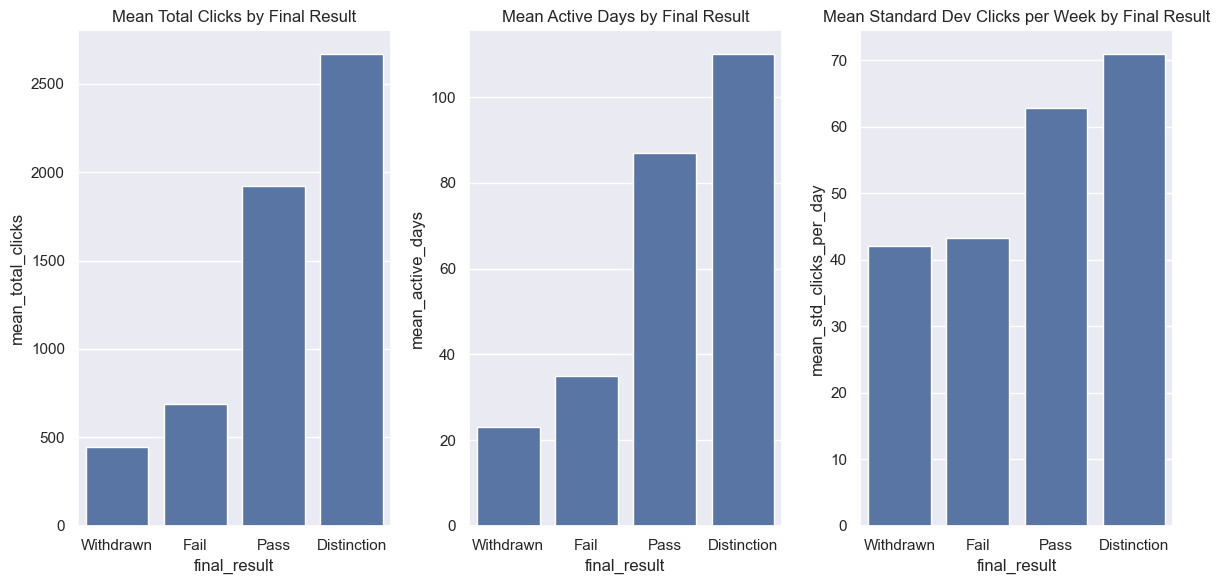

<Figure size 1200x600 with 0 Axes>

In [122]:
days = 300
# Filter out data after set date
student_vle = student_vle[student_vle['date'] < days]


# Calculate days_interacted
days_interacted = student_vle.groupby(['id_student', 'code_module', 'code_presentation'])['date'].nunique().reset_index(name='days_interacted')

#Calculate week
student_vle['week'] = student_vle['date'] // 7
# Group by student, module, presentation, and week, and aggregate clicks
weekly_clicks = student_vle.groupby(['id_student', 'code_module', 'code_presentation', 'week'])['sum_click'].sum().reset_index()

# Now group by student, module, and presentation to calculate the standard deviation of weekly clicks
agg_features = weekly_clicks.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    total_clicks=pd.NamedAgg(column='sum_click', aggfunc='sum'),
    std_weekly_clicks=pd.NamedAgg(column='sum_click', aggfunc='std')
).reset_index()
# Merge with days_interacted
agg_features = agg_features.merge(days_interacted, on=['id_student', 'code_module', 'code_presentation'])


# 
# percentiles = [0.5, 0.75]  # Use values between 0 and 1 for percentiles
# click_percentiles = student_vle.groupby(['id_student', 'code_module', 'code_presentation'], observed=False)['sum_click'].quantile(percentiles)
# click_percentiles = click_percentiles.unstack().reset_index()
# click_percentiles.columns = ['id_student', 'code_module', 'code_presentation'] + [f'click_{p*100}th_percentile' for p in percentiles]
# agg_features = agg_features.merge(click_percentiles, on=['id_student', 'code_module', 'code_presentation'], how='left')

merged_data = pd.merge(agg_features, student_info, on=['id_student', 'code_module', 'code_presentation']).reset_index()
print(merged_data.columns)

# Calculate the means for different final results
mean_values = merged_data.groupby('final_result').agg(
    mean_total_clicks=('total_clicks', 'mean'),
    mean_active_days=('days_interacted', 'mean'),
    mean_std_clicks_per_day=('std_weekly_clicks', 'mean')
).reset_index()


# Define the order of categories
category_order = ["Withdrawn", "Fail", "Pass", "Distinction"]

# Create bar plots to visualize the means for different final results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='final_result', order=category_order, y='mean_total_clicks', data=mean_values)
plt.title('Mean Total Clicks by Final Result')

plt.subplot(1, 3, 2)
sns.barplot(x='final_result', order=category_order, y='mean_active_days', data=mean_values)
plt.title('Mean Active Days by Final Result')

plt.subplot(1, 3, 3)
sns.barplot(x='final_result', order=category_order, y='mean_std_clicks_per_day', data=mean_values)
plt.title('Mean Standard Dev Clicks per Week by Final Result')

plt.tight_layout()
plt.show()

# Create a boxplot to visualize click distribution percentiles by Final Result
plt.figure(figsize=(12, 6))
# plt.subplot(1, 3, 1)
# sns.barplot(x='final_result', order=category_order, y='click_25.0th_percentile', data=merged_data)
# plt.title('Click Distribution - 25th Percentile by Final Result')

# plt.subplot(1, 3, 2)
# sns.barplot(x='final_result', order=category_order, y='click_50.0th_percentile', data=merged_data)
# plt.title('Click Distribution - 50th Percentile by Final Result')
# 
# plt.subplot(1, 3, 3)
# sns.barplot(x='final_result', order=category_order, y='click_75.0th_percentile', data=merged_data)
# plt.title('Click Distribution - 75th Percentile by Final Result')

plt.tight_layout()
plt.show()


## Activity type

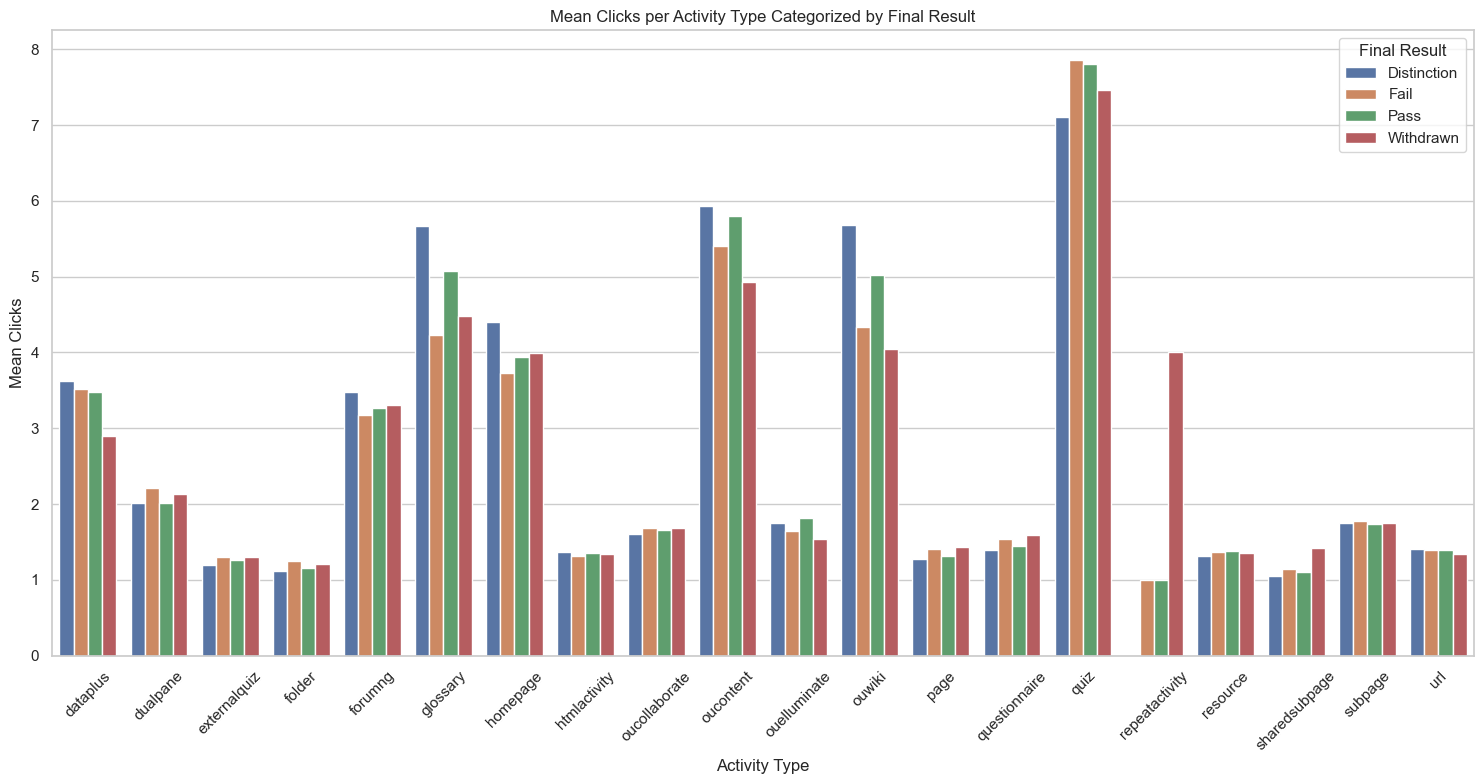

In [83]:
# Merging vle with student_vle
vle_merged = pd.merge(student_vle, vle, on=['code_module', 'code_presentation', 'id_site'])

# Merging the above with student_info
final_merged_data = pd.merge(vle_merged, student_info, on=['code_module', 'code_presentation', 'id_student'])

# Grouping the data by activity type and final result and calculating the mean clicks
mean_clicks_data = final_merged_data.groupby(['activity_type', 'final_result'])['sum_click'].mean().reset_index()

# Visualization with Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x='activity_type', y='sum_click', hue='final_result', data=mean_clicks_data)
plt.xticks(rotation=45)
plt.xlabel('Activity Type')
plt.ylabel('Mean Clicks')
plt.title('Mean Clicks per Activity Type Categorized by Final Result')
plt.legend(title='Final Result')
plt.tight_layout()
plt.show()

# Student Info EDA

In [ ]:
# student = student_info[student_info['code_presentation'] != '2014J']
student_info.head()

In [ ]:
# student_info.describe(include='all')

## Correlation between total VLE interactions and Final Results

                      total_clicks  days_interacted  std_weekly_clicks  \
total_clicks              1.000000         0.827202           0.738908   
days_interacted           0.827202         1.000000           0.475985   
std_weekly_clicks         0.738908         0.475985           1.000000   
final_result_encoded      0.438396         0.577177           0.210261   

                      final_result_encoded  
total_clicks                      0.438396  
days_interacted                   0.577177  
std_weekly_clicks                 0.210261  
final_result_encoded              1.000000  


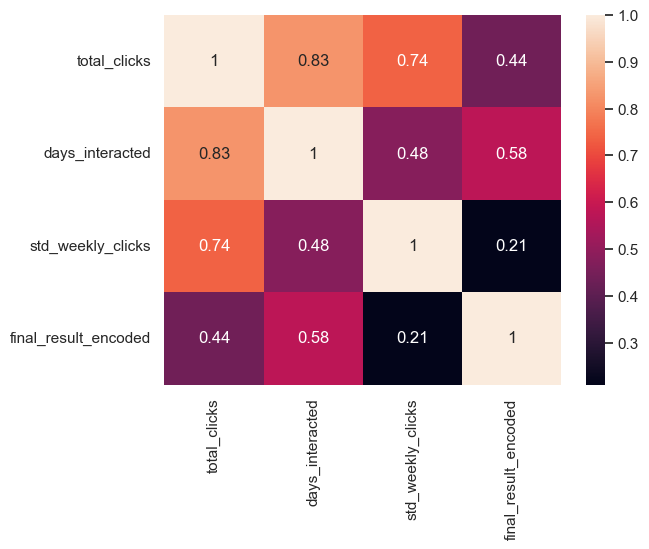

In [123]:
# agg_features = student_vle.groupby(['id_student', 'code_module', 'code_presentation'], observed=False).agg(
#         total_clicks=pd.NamedAgg(column='sum_click', aggfunc='sum'),
#         avg_clicks_per_day=pd.NamedAgg(column='sum_click', aggfunc='mean'),
#         days_interacted=pd.NamedAgg(column='date', aggfunc=lambda x: len(set(x))),
#         std_clicks_per_day=pd.NamedAgg(column='sum_click', aggfunc='std')
#     ).reset_index()

merged_data = pd.merge(agg_features, student_info, on=['id_student', 'code_module', 'code_presentation']).reset_index()

# Encoding the final_result
result_encoding = {'Withdrawn': 0, 'Fail': 1, 'Pass': 2, 'Distinction': 3}
merged_data['final_result_encoded'] = merged_data['final_result'].map(result_encoding)

correlation = merged_data[['total_clicks', 'days_interacted', 'std_weekly_clicks', 'final_result_encoded']].corr()
print(correlation)

sns.heatmap(correlation, annot=True)
plt.show()


# # Calculating the correlation
# correlationclicks = merged_data[['total_clicks', 'final_result_encoded']].corr()
# correlationdays = merged_data[['days_interacted', 'final_result_encoded']].corr()
# correlationavg = merged_data[['avg_clicks_per_day', 'final_result_encoded']].corr()
# correlationstd = merged_data[['std_clicks_per_day', 'final_result_encoded']].corr()

# # Extracting the relevant correlation coefficients
# corr_total_clicks = correlationclicks.loc['total_clicks', 'final_result_encoded']
# corr_days_interacted = correlationdays.loc['days_interacted', 'final_result_encoded']
# corr_avg_clicks_per_day = correlationavg.loc['avg_clicks_per_day', 'final_result_encoded']
# corr_std_clicks_per_day = correlationstd.loc['std_clicks_per_day', 'final_result_encoded']
# 
# # Creating the correlation table
# correlation_table = pd.DataFrame({
#     'Total Clicks': [corr_total_clicks],
#     'Active Days': [corr_days_interacted],
#     'Avg Clicks p/d': [corr_avg_clicks_per_day],
#     'StD of Clicks p/d': [corr_std_clicks_per_day]
# }, index=['Final Result'])
# 
# # Printing the correlation table
# print("Correlation Table with Final Result")
# print(correlation_table)



# Plotting the correlation between total clicks and final result
# sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=merged_data, x='total_clicks', y='final_result_encoded', alpha=0.5)

# plt.title('Correlation between Total VLE Interactions and Final Results')
# plt.xlabel('Total Number of Clicks (VLE Interactions)')
# plt.ylabel('Final Result (Encoded)')
# plt.xticks(rotation=45)
# plt.yticks([-1, 0, 1, 2], ['Withdrawn', 'Fail', 'Pass', 'Distinction'])
# plt.savefig(f"{images_dir}/studentvle-finalres.png")
# plt.show()